# 📣 수산화나트륨에 의한 크리스탈 바이올렛의 탈색 반응 📣
### 반응속도의 농도 의존성: 크리스탈 바이올렛과 수산화나트륨 농도에 대한 반응차수를 구해보자. 
1. ExportedData.csv 의 경로를 복사하세요. 
2. ⨠모두 실행(Run) 을 하고, 복사한 CSV 파일의 경로와 전체 시행 횟수를 입력합니다. 
3. ex) Run #1, Run #2, Run #4, Run #5 만 있다면 시행횟수는 4입니다.
4. 최대 흡수 파장에서의 몰 흡광계수를 입력합니다. 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.metrics import r2_score

# Dataframe 만들기
path_CSV = input('복사한 CSV의 경로를 입력하세요: ')
path_CSV = path_CSV.strip("'")  # 앞뒤의 작은 따옴표 제거
# print(path_CSV)
data = pd.read_csv(path_CSV)

# Run 횟수 받기
Run_number = int(input('총 몇 번 시행 하였나요?'))

# 몰 흡광계수 정보 입력받기
absorption_coefficient = float(input('최대 흡수 파장에서의 몰 흡광계수(M-1cm-1)를 입력하세요.')) # /Mcm
convert_unit = 1000 # mM 로 나타내야 함. 
cell_length = 1 #cm

# column 이름 변경하기
# data.rename(columns={'Time (s)' : 'Time'}, inplace=True)
data.columns = [col.replace('time (s)', 'Time').replace('Time (s)', 'Time') for col in data.columns]

# 칼럼만 추출하기 
data_filter_1 = data.filter(regex='Time')
data_filter_2 = data.filter(regex='Concentration')


# 새로운 Dataframe 만들기 : 시간과 농도 칼럼만 남기기 
new_dataframe = pd.concat([data_filter_1, data_filter_2], axis=1)

# Concentration 칼럼 이름 동적으로 변경하기
new_column_names = ['Time'] + [f'Concentration (mol/L) Run #{i+1}' for i in range(Run_number)]


# 새로운 칼럼 이름을 설정
new_dataframe.columns = new_column_names

# print(new_dataframe)




# 가. 실행한 모든 그래프를 그려보자. 

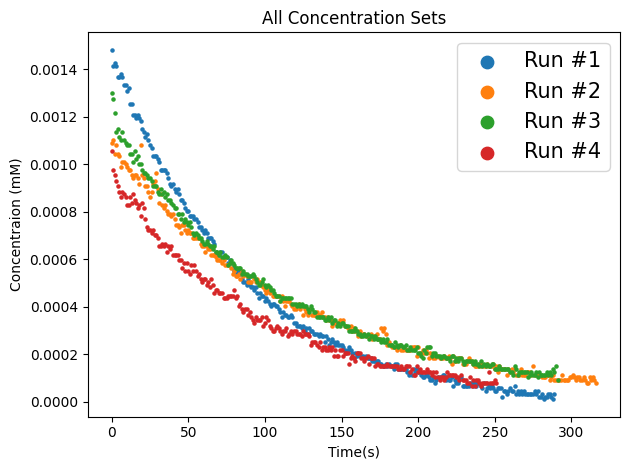

In [15]:
for i in range(Run_number):
    Filtered_data = new_dataframe[new_dataframe[f'Concentration (mol/L) Run #{i+1}'] >= 0.001]
    x_data = Filtered_data['Time'].values
    y_data = Filtered_data[f'Concentration (mol/L) Run #{i+1}'].values
    y_data = (y_data *  convert_unit) / (absorption_coefficient * cell_length) # 단위는 mM
    plt.scatter(x_data, y_data, s = 5, label = f'Run #{i+1}')  # 각각의 데이터에 대해 plot
plt.title('All Concentration Sets')  # 제목 설정
plt.xlabel('Time(s)')
plt.ylabel('Concentraion (mM)')
plt.legend(fontsize = 15, markerscale = 4)


# 전체 plot을 보여줌
plt.tight_layout()
plt.show()

# 나. 반응차수 구하기 1: 회귀분석 이용하기
### n 차 반응이라고 가정하고 Crystal violet 의 농도에 대해 graph fitting을 해보자

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


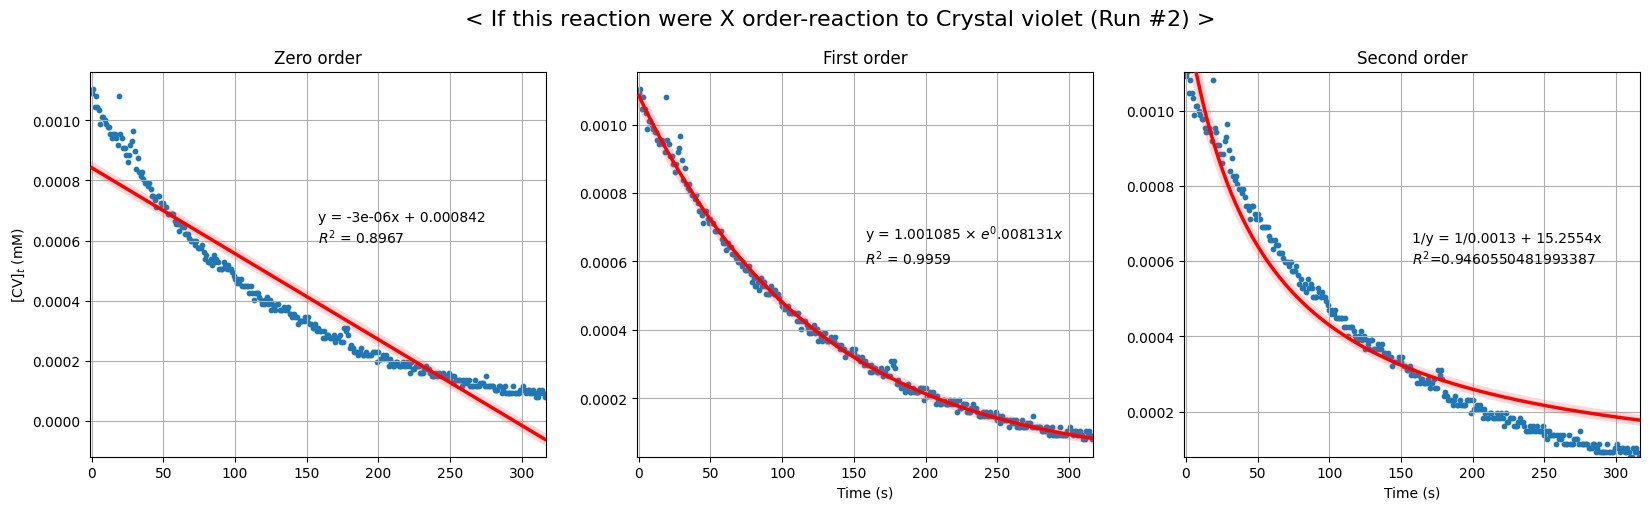

In [16]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

Which_Run_Do_You_Want_to = int(input('몇 번째 시행에 대해 분석하고 싶은가요?'))

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
Filtered_data_for_regression = new_dataframe[new_dataframe[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'] >= 0.001]
Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'] = (Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'] * convert_unit) / (absorption_coefficient * cell_length)
# 단위 mM로 변환했음.

#curve_fit용 함수 지정
def func_0(t, a, b):
    return a * t + b

def func_1(t, a, b):
    return b * np.exp(- a * t)

def func_2(t, a, b):
    return b / (1 + (b * a * t))

t = Filtered_data_for_regression['Time']
y = Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}']


popt_0, pcov_0 = curve_fit(func_0, t , y)
popt_1, pcov_1 = curve_fit(func_1, t , y)
popt_2, pcov_2 = curve_fit(func_2, t , y)



# 첫 번째 서브플롯: 0차 가정
axes[0].scatter(Filtered_data_for_regression['Time'],
                Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'], 
                s = 10, zorder = 1)
axes[0].set_xlim(Filtered_data_for_regression['Time'].min()-1, 
                 Filtered_data_for_regression['Time'].max()+1)
axes[0].grid(True)
axes[0].set_title(f'Zero order')


axes[0].plot(Filtered_data_for_regression['Time'],
             (popt_0[0] * Filtered_data_for_regression['Time'] + popt_0[1]),
             color = 'r', 
             linewidth = 2.5, zorder = 3)
axes[0].plot(Filtered_data_for_regression['Time'],
             (popt_0[0] * Filtered_data_for_regression['Time'] + popt_0[1]),
             color = '#F24444', alpha = 0.2,
             linewidth = 8, zorder = 2)


# 추정된 y 값 계산
est_y = np.array(Filtered_data_for_regression['Time']) * popt_0[0] + popt_0[1]

# R^2 값 계산
r2 = r2_score(Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'], est_y)

axes[0].text((Filtered_data_for_regression['Time'].min() + Filtered_data_for_regression['Time'].max()) / 2,
             (Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].min() + 
              Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].max()) / 2,
             f'y = {round(popt_0[0], 6)}x + {round(popt_0[1], 6)}\n$R^2$ = {round(r2, 4)}')

axes[0].set_ylabel(r'$\text{[CV]}_t$ (mM)')




# 두 번째 서브플롯: 1차 가정
axes[1].scatter(t,
                y, 
                s = 10, zorder = 1)
axes[1].set_xlim(Filtered_data_for_regression['Time'].min()-1, 
                 Filtered_data_for_regression['Time'].max()+1)
axes[1].grid(True)
axes[1].set_title(f'First order')

# 추정된 y 값 계산
est_y_2 = popt_1[1] * np.exp(-popt_1[0] * t)

axes[1].plot(t,
             popt_1[1] * np.exp(-popt_1[0] * t),
             color = 'r', 
             linewidth = 2.5, zorder = 3)
axes[1].plot(t,
             popt_1[1] * np.exp(-popt_1[0] * t),
             color = '#F24444', alpha = 0.2,
             linewidth = 8, zorder = 2)

# R^2 값 계산
r2 = r2_score(Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'], est_y_2)

# axes[1].set_ylabel(r'$\text{[CV]}_t$')
axes[1].text((Filtered_data_for_regression['Time'].min() + Filtered_data_for_regression['Time'].max()) / 2,
             (Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].min() + 
              Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].max()) / 2,
             f'y = {round(np.e ** popt_1[1], 6)} ' r'$\times$' f' $e^{round(popt_1[0], 6)}x$\n$R^2$ = {round(r2, 4)}')
axes[1].set_xlabel('Time (s)')


# 세 번째 서브플롯 : 2차 반응
axes[2].scatter(Filtered_data_for_regression['Time'],
                Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'], 
                s = 10, zorder = 1)
axes[2].set_xlim(Filtered_data_for_regression['Time'].min()-1, 
                 Filtered_data_for_regression['Time'].max()+1)
axes[2].grid(True)
axes[2].set_title(f'Second order')
axes[2].set_xlabel('Time (s)')



# 추정된 y 값 계산
est_y_3 = popt_2[1] / (1 + (popt_2[1] * popt_2[0] * t))

# R^2 값 계산
r2 = r2_score(Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'], est_y_3)


axes[2].plot(Filtered_data_for_regression['Time'],
             est_y_3,
             color = 'r', 
             linewidth = 2.5, zorder = 3)
axes[2].plot(Filtered_data_for_regression['Time'],
             est_y_3,
             color = '#F24444', alpha = 0.2,
             linewidth = 8, zorder = 2)
axes[2].set_ylim(Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].min(), Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].max())

# axes[2].set_ylabel(r'$\text{[CV]}_t$')
axes[2].text((Filtered_data_for_regression['Time'].min() + Filtered_data_for_regression['Time'].max()) / 2,
             (Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].min() + 
              Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].max()) / 2,
             f'1/y = 1/{round(popt_2[1],4)} + {round(popt_2[0],4)}x\n'r'$R^{2}$' f'={r2}')



fig.suptitle(f"< If this reaction were X order-reaction to Crystal violet (Run #{Which_Run_Do_You_Want_to}) >", 
             fontsize=16, 
             y = 1.005)

plt.show()

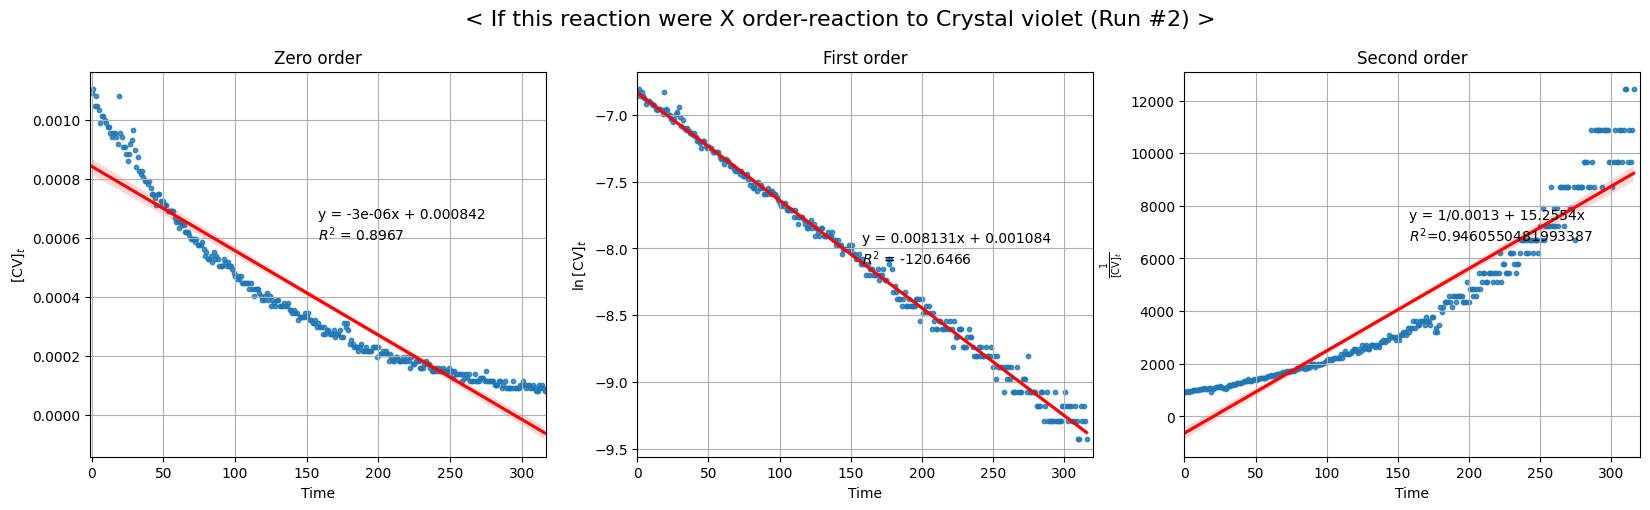

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
Filtered_data_for_regression = new_dataframe[new_dataframe[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'] >= 0.001]
Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'] = (Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'] * convert_unit) / (absorption_coefficient * cell_length)

sns.regplot(x='Time', 
            y=f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}', 
            data=Filtered_data_for_regression, 
            ax=axes[0], 
            scatter_kws = {'s':10}, 
            line_kws = {'color':'red'})
axes[0].set_xlim(Filtered_data_for_regression['Time'].min()-1, 
                 Filtered_data_for_regression['Time'].max()+1)
axes[0].grid(True)
axes[0].set_title(f'Zero order')



# R^2 값 계산
r2 = r2_score(Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'], est_y)

axes[0].text((Filtered_data_for_regression['Time'].min() + Filtered_data_for_regression['Time'].max()) / 2,
             (Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].min() + 
              Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].max()) / 2,
             f'y = {round(popt_0[0], 6)}x + {round(popt_0[1], 6)}\n$R^2$ = {round(r2, 4)}')

axes[0].set_ylabel(r'$\text{[CV]}_t$')




# 두 번째 서브플롯: 1차 가정
sns.regplot(x = Filtered_data_for_regression['Time'], 
            y = np.log(Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}']), 
            ax=axes[1], 
            scatter_kws = {'s':10}, 
            line_kws = {'color':'red'})
axes[1].set_xlim(Filtered_data_for_regression['Time'].min()-(Filtered_data_for_regression['Time'].min()*0.15), 
                 Filtered_data_for_regression['Time'].max()+(Filtered_data_for_regression['Time'].max()*0.015))
axes[1].grid(True)
axes[1].set_title(f'First order')


# R^2 값 계산
r2 = r2_score(np.log(Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}']), est_y_2)

axes[1].set_ylabel(r'$\ln{\text{[CV]}_t}$')
axes[1].text((Filtered_data_for_regression['Time'].min() + Filtered_data_for_regression['Time'].max()) / 2,
             (np.log(Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].min()) + 
              np.log(Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].max())) / 2,
             f'y = {round(popt_1[0], 6)}x + {round(popt_1[1], 6)}\n$R^2$ = {round(r2, 4)}')


# 세 번째 서브플롯 : 2차 반응
sns.regplot(x = Filtered_data_for_regression['Time'], 
            y = 1 / (Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}']), 
            ax=axes[2], 
            scatter_kws = {'s':10}, 
            line_kws = {'color':'red'})
axes[2].set_xlim(Filtered_data_for_regression['Time'].min()-(Filtered_data_for_regression['Time'].min()*0.15), 
                 Filtered_data_for_regression['Time'].max()+(Filtered_data_for_regression['Time'].max()*0.015))
axes[2].grid(True)
axes[2].set_title(f'Second order')



# R^2 값 계산
r2 = r2_score(Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'], est_y_3)

axes[2].set_ylabel(r'$\frac{1}{\text{[CV]}_t}$')
axes[2].text((Filtered_data_for_regression['Time'].min() + Filtered_data_for_regression['Time'].max()) / 2,
             (1 / (Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].min()) + 
              1 / (Filtered_data_for_regression[f'Concentration (mol/L) Run #{Which_Run_Do_You_Want_to}'].max())) / 2,
             f'y = 1/{round(popt_2[1],4)} + {round(popt_2[0],4)}x\n'r'$R^{2}$' f'={r2}')

fig.suptitle(f"< If this reaction were X order-reaction to Crystal violet (Run #{Which_Run_Do_You_Want_to}) >", 
             fontsize=16, 
             y = 1.005)


plt.show()

# 나. 반응차수 구하기 2: 반감기 이용하기
### 반감기를 통해 Crystal violet 농도에 대한 차수를 구해보자

In [19]:
import pandas as pd
import numpy as np



# C_VS 정의
C_VS = ['~1/2[CV]0', '~1/4[CV]0', '~1/8[CV]0', '~1/16[CV]0', '~1/32[CV]0']

# 결과를 저장할 딕셔너리 생성
results = {}

# 각 Run에 대한 데이터를 저장하는 루프
for i in range(Run_number):
    Filtered_data_for_regression = new_dataframe[new_dataframe[f'Concentration (mol/L) Run #{i+1}'] >= 0.001]

    # 변수 쉽게 지정하기
    x = Filtered_data_for_regression['Time']
    y = Filtered_data_for_regression[f'Concentration (mol/L) Run #{i+1}']

    # 반감기 list 만들기
    C_0 = y.iloc[0]

    half_life_that_time = []
    C = []
    

    # 농도의 1/32 까지 구할 것임.
    for n in [0, 1, 2, 3, 4, 5]:
        y_value = (0.5 ** n) * C_0
        C.append(y_value)
        closest_idx = np.argmin(np.abs(y - y_value))  # 가장 가까운 농도에 해당하는 시간 찾기
        closest_time = x.iloc[closest_idx]
        
        # 중복된 값이 아니면 half_life_that_time 리스트에 추가
        if closest_time not in half_life_that_time:
            half_life_that_time.append(closest_time)

    # half_life_that_time 리스트가 6개의 값을 가지도록 빈 값을 추가 (NaN으로 처리)
    while len(half_life_that_time) < 6:
        half_life_that_time.append(np.nan)
        
    half_life_that_time.pop(0)

    # 결과 딕셔너리에 저장
    results[f'Run #{i+1}'] = half_life_that_time
    
    

# 결과 딕셔너리로 데이터프레임 생성
df = pd.DataFrame(results, index=C_VS)

# 행렬 전치
df_transposed = df.T

# NaN 값을 빈 문자열로 대체하여 출력
df_transposed = df_transposed.fillna('')

# 전치된 데이터프레임 출력
print(df_transposed)


        ~1/2[CV]0  ~1/4[CV]0  ~1/8[CV]0  ~1/16[CV]0 ~1/32[CV]0
Run #1       57.0      113.0      158.0       208.0      244.0
Run #2       79.0      161.0      250.0       310.0           
Run #3       64.0      147.0      230.0       291.0           
Run #4       56.0      115.0      187.0       235.0           
